# Twitter Bot Classifer Part 3

In this series of notebooks, we are using the [Fake Project](https://botometer.iuni.iu.edu/bot-repository/datasets.html) dataset to examine users habits and build a Twitter bot classifer. 

 ### Workflow 
 1. Understand the problem (we're almost there already)
 2. Exploratory Data Analysis
 3. Feature engineering for machine learning
 4. Create a baseline machine learning model
 5. Try more complex machine learning models
 6. Optimize models
 7. Investigate model predictions in context of problem
 8. Exmaine users characteristics by clustering
 9. Draw conclusions and lay out next steps
 
The first notebook covered steps 1 by looking into the problem and assembling datasets. Now, we will complete steps 2-9.

In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#NLP tools
import string
import re
import nltk
from nltk.corpus import stopwords
from googletrans import Translator

# NLP feature selection 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# Sklearn data clean
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Logistic Regression
from sklearn.linear_model import Lasso, LogisticRegression

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn.ensemble import RandomForestClassifier

# SVM
from sklearn.svm import SVC

# Gradient Boost
from xgboost import XGBClassifier

# Evaluate
from sklearn import metrics
from sklearn.metrics import log_loss,accuracy_score, f1_score,roc_auc_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Datetime
from datetime import datetime

# Import data
import warnings

# Clustering 
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


In [2]:
tweets = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_tweets2')
users = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/cresci-2017.csv/datasets_full.csv/clean_users2')

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283436 entries, 0 to 6283435
Data columns (total 18 columns):
id                       int64
text                     object
source                   object
user_id                  int64
in_reply_to_status_id    int64
in_reply_to_user_id      int64
retweeted_status_id      int64
retweet_count            int64
reply_count              int64
favorite_count           int64
num_hashtags             int64
num_urls                 int64
num_mentions             int64
created_at               object
timestamp                object
crawled_at               object
updated                  object
class                    int64
dtypes: int64(12), object(6)
memory usage: 862.9+ MB


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7989 entries, 0 to 7988
Data columns (total 24 columns):
id                                    7989 non-null int64
name                                  7989 non-null object
screen_name                           7989 non-null object
statuses_count                        7989 non-null int64
followers_count                       7989 non-null int64
friends_count                         7989 non-null int64
favourites_count                      7989 non-null int64
listed_count                          7989 non-null int64
lang                                  7989 non-null object
profile_image_url                     7989 non-null object
profile_use_background_image          7989 non-null int64
profile_background_image_url_https    7989 non-null object
profile_text_color                    7989 non-null object
profile_image_url_https               7989 non-null object
profile_sidebar_border_color          7989 non-null object
profile_sidebar

### Convert time variables to datetime 
It doesn't appear that time variables such as timestamp or created_at were saved as datetime. We will convert them to their respective data type. 

In [5]:
# Convert the time columns to np.datetime object
tweets['timestamp'] = pd.to_datetime(tweets['timestamp'])

In [6]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [7]:
tweets['crawled_at'] = pd.to_datetime(tweets['crawled_at'])

In [8]:
tweets['updated'] = pd.to_datetime(tweets['updated'])

In [9]:
# Convert the created_at column to np.datetime object
users['timestamp'] = pd.to_datetime(users['timestamp'])

In [10]:
users['created_at'] = pd.to_datetime(users['created_at'])

In [11]:
users['crawled_at'] = pd.to_datetime(users['crawled_at'])

In [12]:
users['updated'] = pd.to_datetime(users['updated'])

In [13]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283436 entries, 0 to 6283435
Data columns (total 18 columns):
id                       int64
text                     object
source                   object
user_id                  int64
in_reply_to_status_id    int64
in_reply_to_user_id      int64
retweeted_status_id      int64
retweet_count            int64
reply_count              int64
favorite_count           int64
num_hashtags             int64
num_urls                 int64
num_mentions             int64
created_at               datetime64[ns, UTC]
timestamp                datetime64[ns]
crawled_at               datetime64[ns]
updated                  datetime64[ns]
class                    int64
dtypes: datetime64[ns, UTC](1), datetime64[ns](3), int64(12), object(2)
memory usage: 862.9+ MB


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7989 entries, 0 to 7988
Data columns (total 24 columns):
id                                    7989 non-null int64
name                                  7989 non-null object
screen_name                           7989 non-null object
statuses_count                        7989 non-null int64
followers_count                       7989 non-null int64
friends_count                         7989 non-null int64
favourites_count                      7989 non-null int64
listed_count                          7989 non-null int64
lang                                  7989 non-null object
profile_image_url                     7989 non-null object
profile_use_background_image          7989 non-null int64
profile_background_image_url_https    7989 non-null object
profile_text_color                    7989 non-null object
profile_image_url_https               7989 non-null object
profile_sidebar_border_color          7989 non-null object
profile_sidebar

In [15]:
tweets.head()

,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
0,515447020405137408,"""Il mare d'inverno è un concetto che il pensie...","<a href=""http://www.Matildadr89.com"" rel=""nofo...",237359828,0,0,0,0,0,0,0,0,0,2014-09-26 10:25:20+00:00,2014-09-26 12:25:20,2014-11-13 01:35:24,2014-11-13 01:35:24,1
1,513551196226093057,Read the History of Corona Beer http://t.co/Z...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",215693377,0,0,0,0,0,0,0,1,0,2014-09-21 04:52:01+00:00,2014-09-21 06:52:01,2014-11-12 23:35:05,2014-11-12 23:35:05,1
2,579534763872149504,After that it would of been up to the person i...,"<a href=""http://twitter.com/download/iphone"" r...",164284493,0,0,0,0,0,0,0,0,0,2015-03-22 06:47:09+00:00,2015-03-22 07:47:09,2015-05-01 13:21:46,2015-05-01 13:21:46,0
3,449751137970028544,RT @kcivey: @marionbarryjr I'm for public fina...,"<a href=""http://twitter.com/download/iphone"" r...",225683965,0,0,449735142085779456,1,0,0,0,0,2,2014-03-29 03:33:21+00:00,2014-03-29 04:33:21,2015-05-01 15:58:20,2015-05-01 15:58:20,0
4,589197488269045760,RT @specuIar: This hit me hard. http://t.co/rY...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",505440359,0,0,589196377353097216,1300,0,0,0,0,1,2015-04-17 22:43:22+00:00,2015-04-18 00:43:22,2015-05-01 13:21:33,2015-05-01 13:21:33,0


In [16]:
users.head()

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,profile_image_url,...,profile_sidebar_border_color,profile_sidebar_fill_color,profile_background_image_url,profile_background_color,profile_link_color,created_at,timestamp,crawled_at,updated,class
0,2349966440,Joie Ficher,JoieFicher,80,2,42,0,0,en,http://pbs.twimg.com/profile_images/4365494921...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-02-18 11:22:38+00:00,2014-02-18 12:22:38,2014-05-03 00:22:39,2016-03-15 15:20:24,1
1,343263643,RIP Teveon ,youpettihoe_,36513,2166,1627,2977,0,en,http://pbs.twimg.com/profile_images/5594447898...,...,FFFFFF,FFFFFF,http://pbs.twimg.com/profile_background_images...,FFFAFF,0A7A00,2011-07-27 09:01:04+00:00,2011-07-27 11:01:04,2015-05-01 23:18:23,2016-03-15 16:11:13,0
2,531154412,Bulah Lynne,Lynnevibe,10657,1194,996,1,8,en,http://pbs.twimg.com/profile_images/1914097815...,...,C0DEED,DDEEF6,http://abs.twimg.com/images/themes/theme1/bg.png,C0DEED,0084B4,2012-03-20 11:48:05+00:00,2012-03-20 12:48:05,2014-05-05 23:24:32,2016-03-15 15:40:08,1
3,2377665366,Katherina Kistle,KatherinaKistle,37,0,38,0,0,en,http://pbs.twimg.com/profile_images/4430041788...,...,FFFFFF,DDEEF6,http://pbs.twimg.com/profile_background_images...,0000FF,0000FF,2014-03-07 21:23:35+00:00,2014-03-07 22:23:35,2014-05-05 00:21:50,2016-03-15 15:16:15,1
4,3015346510,Lindsay Blessing Fan,lindsayspainfan,96,43,113,425,0,es,http://pbs.twimg.com/profile_images/5631073115...,...,000000,000000,http://pbs.twimg.com/profile_background_images...,000000,9266CC,2015-02-03 20:49:38+00:00,2015-02-03 21:49:38,2015-05-02 01:09:46,2016-03-15 16:07:16,0


### Examine 'user_id' in Tweets table
In an attempt to 'clean' the data, I tried to remove user accounts that did not have an associated tweet. If an _id_ in the Users table was not present in the _user_id_ column of the Tweets table, that account should be removed in the Users table. However, there doesn't appear to be common user ids between the two tables. This might have been done to protect the privacy of the account users. 

Before we continue, let's confirm whether user ids in the Tweets table are unique to each account. First, we'll partition the dataset by class and then merge on _user_id_ to see if there is overlap. 


In [140]:
# Create df for user class
bots = tweets.loc[tweets['class']==1]
gen = tweets.loc[tweets['class']==0]

In [141]:
bots = pd.DataFrame(bots)
gen = pd.DataFrame(gen)

In [143]:
merge = bots.merge(gen, on='user_id')

In [144]:
print(merge)

Empty DataFrame
Columns: [id_x, text_x, source_x, user_id, in_reply_to_status_id_x, in_reply_to_user_id_x, retweeted_status_id_x, retweet_count_x, reply_count_x, favorite_count_x, num_hashtags_x, num_urls_x, num_mentions_x, created_at_x, timestamp_x, crawled_at_x, updated_x, class_x, id_y, text_y, source_y, in_reply_to_status_id_y, in_reply_to_user_id_y, retweeted_status_id_y, retweet_count_y, reply_count_y, favorite_count_y, num_hashtags_y, num_urls_y, num_mentions_y, created_at_y, timestamp_y, crawled_at_y, updated_y, class_y]
Index: []

[0 rows x 35 columns]


Looks like each _user_id_ is specific to each class. We'll also check if the unique amount of _user_id_ for each class adds up to the total _user_id_ of the dataset. 

In [128]:
# Total user_id count 
len(tweets['user_id'].unique().tolist())

5995

In [133]:
# Number of unique user accounts
len(bots['user_id'].unique().tolist())

4912

In [134]:
# Number of unique user accounts
len(gen['user_id'].unique().tolist())

1083

In [136]:
print((len(bots['user_id'].unique().tolist())+(len(gen['user_id'].unique().tolist()))))

5995


Here, we can see there are 4,912 bot users and 1083 human users that make make up 5,995 total unique accounts. 

In [20]:
# Counts of unique user accounts 
bots['user_id'].value_counts()

521370115     3258
334826952     3250
221141363     3250
239910996     3250
982414274     3250
              ... 
2382422750      66
2375328500      64
2382743514      63
2391867347      43
2384976224      38
Name: user_id, Length: 4912, dtype: int64

To confirm that these user ids are unique to the bots account, we will select a few user ids to verify that they only belong to the specific user in the Tweets table. 

Let's start by verifying _user_id_: 521370115

In [21]:
# Create df with selected user id 
user_id = tweets[tweets['user_id']==521370115]
user_id.head()

,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class
1351,514086444387008513,Read the History of Journey http://t.co/DGLvo...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",521370115,0,0,0,0,0,0,0,1,0,2014-09-22 16:18:54+00:00,2014-09-22 18:18:54,2014-11-13 03:10:13,2014-11-13 03:10:13,1
5270,518798551498096640,"If it weren't for baseball, many kids wouldn't...","<a href=""http://tweetadder.com"" rel=""nofollow""...",521370115,0,0,0,0,0,0,0,0,0,2014-10-05 16:23:08+00:00,2014-10-05 18:23:08,2014-11-13 03:10:11,2014-11-13 03:10:11,1
5817,521430185942724609,Before you create anymore great content figure...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",521370115,0,0,0,0,0,0,0,0,0,2014-10-12 22:40:18+00:00,2014-10-13 00:40:18,2014-11-13 03:10:08,2014-11-13 03:10:09,1
6142,513408584437096448,Running SUCKS! How to Run for Fast Weight Loss...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",521370115,0,0,0,0,0,0,0,1,0,2014-09-20 19:25:19+00:00,2014-09-20 21:25:19,2014-11-13 03:10:13,2014-11-13 03:10:13,1
8566,517016238703509505,Check Out these Cool Types of Garage Flooring ...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",521370115,0,0,0,0,0,0,0,1,0,2014-09-30 18:20:51+00:00,2014-09-30 20:20:51,2014-11-13 03:10:12,2014-11-13 03:10:12,1


Now, let's check if this user id is associated with a human class (0).

In [22]:
# Count of class 
user_id['class'].value_counts()

1    3258
Name: class, dtype: int64

In [23]:
# Verify another user id 
user_id2 = tweets[tweets['user_id']==2384976224]

# Count of class 
user_id2['class'].value_counts()

1    38
Name: class, dtype: int64

It does look like that the user ids are unique to specific accounts. Let's verify some genuine accounts before we move on. 

In [24]:
# Number of unique user accounts
len(gen['user_id'].unique().tolist())

1083

In [25]:
# Counts of unique user accounts 
gen['user_id'].value_counts()

15044720      3250
497404180     3249
182211050     3247
195076965     3247
14626600      3247
              ... 
492728332       24
2236789484      15
2200425967      14
24386710        13
514061230        3
Name: user_id, Length: 1083, dtype: int64

In [26]:
# Create df with selected user id 
user_id3 = tweets[tweets['user_id']==15044720]

# Count of class 
user_id3['class'].value_counts()

0    3250
Name: class, dtype: int64

In [27]:
# Verify another user id 
user_id4 = tweets[tweets['user_id']==514061230]

# Count of class 
user_id4['class'].value_counts()

0    3
Name: class, dtype: int64

## Examine Time variables

## Exploratory Data Analysis
We'll start by exploring the Tweets table by keeping a few questions in mind.<br> 
__How many tweets were made by humans and robots?__ <br>
__Which accounts posted the most tweets?__ <br>

In [28]:
# Bot vs human tweets 
counts = tweets['class'].value_counts()
human = counts[0]
bot = counts[1]
human_per = (human/(human + bot))*100
bot_per = (bot/(human + bot))*100
print('There are {} tweets made by humans({:.3f}%) and {} tweets made by bots ({:.3f}%) in the tweets table.'.format(human, human_per, bot, bot_per))

There are 2826718 tweets made by humans(44.987%) and 3456718 tweets made by bots (55.013%) in the tweets table.


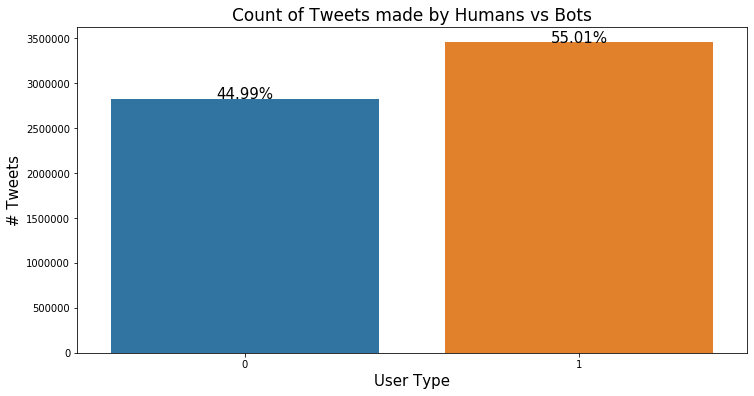

In [29]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'class', data = tweets)
g.set_title('Count of Tweets made by Humans vs Bots', fontsize = 17)
g.set_xlabel('User Type', fontsize = 15)
g.set_ylabel('# Tweets', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(tweets) * 100),
            ha="center", fontsize=15) 

As shown in the bar graph, the data consists of 45% tweets by humans and 55% tweets by robots. The ratio between human to robot tweets are close so we do not have an imbalance problem. 

Let's look at which accounts tweeted the most. 

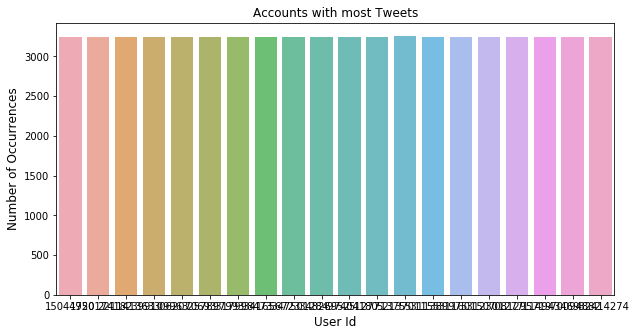

In [30]:
t_per_user = tweets['user_id'].value_counts()
t_per_user = t_per_user[:20,]
plt.figure(figsize=(10,5))
sns.barplot(t_per_user.index, t_per_user.values, alpha=0.8)
plt.title('Accounts with most Tweets')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('User Id', fontsize=12)
plt.show()

In [31]:
# Bot vs human tweets 
counts = users['class'].value_counts()
human = counts[0]
bot = counts[1]
human_per = (human/(human + bot))*100
bot_per = (bot/(human + bot))*100
print('There are {} genuine accounts({:.3f}%) and {} spambot accounts ({:.3f}%) in the users table.'.format(human, human_per, bot, bot_per))

There are 3083 genuine accounts(38.591%) and 4906 spambot accounts (61.409%) in the users table.


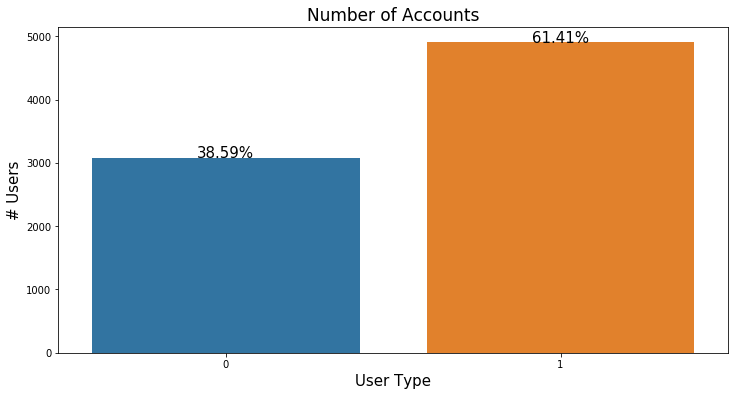

In [32]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'class', data = users)
g.set_title('Number of Accounts', fontsize = 17)
g.set_xlabel('User Type', fontsize = 15)
g.set_ylabel('# Users', fontsize = 15)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(users) * 100),
            ha="center", fontsize=15) 

In [33]:
# tweets per day

In [34]:
# tweet over time 

In [35]:
# pauses between tweets

In [36]:
# creation time

In [37]:
#def hr_func(ts):
    #return ts.hour

In [38]:
#df['hour_tweet'] = users['timestamp'].apply(hr_func)

In [39]:
# number of retweets / total posts

In [40]:
# ratio of numbers in screen_name

## Subsampling 

Due to hardware and memory limitations, we will reduce the size of the dataset and subsample 0.05% of tweets

In [41]:
sub_tweets = tweets.groupby('class').apply(pd.DataFrame.sample, frac=0.005).reset_index(drop=True)

In [42]:
sub_tweets.shape

(31418, 18)

## Clean Tweets
We will clean the tweets with the following steps:
 * NOTE: Unable to Translate Italian tweets to English [Source](https://pypi.org/project/googletrans/)
 * Remove hyperlinks, mentions, and 'RT' from retweets
 * Word Counts with CountVectorizer: 
     - Tokenization: Converting a sentence into a list of words
     - Remove stopwords
     - Lammentization/stemming: Converting any form of a word ot its root word
     - Returns vectors of the counts of each word* 
 * Word Frequencies with TfidfVectorizer:
     - Term Frequency: This summarizes how often a given word appears within a document.
     - Inverse Document Frequency: This downscales words that appear a lot across documents. <br>

Reference:
[clean tweet](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)
 
First, we will paritation the clean_tweets into separate classes for building bag of words and cut down on processing time for CountVectorizer and TfidTransformer. 
 
Let's start by cleaning the bot tweets. 
 

In [43]:
sub_tweets['text'] = sub_tweets['text'].astype('str')

In [44]:
# Create df for user class
bots = sub_tweets.loc[sub_tweets['class']==1]
gen = sub_tweets.loc[sub_tweets['class']==0]

In [45]:
# Create new df 
b_tweets = pd.DataFrame(bots['text'])
b_tweets.head()

,text
14134,-Ma perché bevi il vino con la cannuccia?-. -P...
14135,Nessuno seduce nessuno. È solo chimica e affin...
14136,Check Out The Top 10 European Beers http://t....
14137,A shoe without sex appeal is as barren as a tr...
14138,I grandi Dubbi!! Ma RIN TIN TIN... è un cane c...


In [46]:
# Create new df  
g_tweets = pd.DataFrame(gen['text'])
g_tweets.head()

,text
0,#followmekarisma !!❤❤
1,Shiiitt
2,"In AK: no electricity, no phone, no wine. 1 lu..."
3,Wifi
4,Pizza favourited 1 of my tweets. Pizza is my f...


Let's clean the tweets to remove links, @, and RT.

In [47]:
def text_cleaner(text):
    text = re.sub(r'http.*','',text)
    text = re.sub("@[A-Za-z0-9]+",'',text)
    text = re.sub(r'bit/ly.*', '', text)
    text = re.sub(r'b\'', '', text)
    text = re.sub(r'b"', '', text)
    text = text.replace('RT', '')
    return text

b_tweets['clean_tweets'] = b_tweets['text'].apply(lambda x: text_cleaner(x))

b_tweets.head()

,text,clean_tweets
14134,-Ma perché bevi il vino con la cannuccia?-. -P...,-Ma perché bevi il vino con la cannuccia?-. -P...
14135,Nessuno seduce nessuno. È solo chimica e affin...,Nessuno seduce nessuno. È solo chimica e affin...
14136,Check Out The Top 10 European Beers http://t....,Check Out The Top 10 European Beers
14137,A shoe without sex appeal is as barren as a tr...,A shoe without sex appeal is as barren as a tr...
14138,I grandi Dubbi!! Ma RIN TIN TIN... è un cane c...,I grandi Dubbi!! Ma RIN TIN TIN... è un cane c...


In [48]:
g_tweets['clean_tweets'] = g_tweets['text'].apply(lambda x: text_cleaner(x))

g_tweets.head()

,text,clean_tweets
0,#followmekarisma !!❤❤,#followmekarisma !!❤❤
1,Shiiitt,Shiiitt
2,"In AK: no electricity, no phone, no wine. 1 lu...","In AK: no electricity, no phone, no wine. 1 lu..."
3,Wifi,Wifi
4,Pizza favourited 1 of my tweets. Pizza is my f...,Pizza favourited 1 of my tweets. Pizza is my f...


In [49]:
# Return only characters 
def clean_alpha(text):
    text = " ".join(re.split("[^a-zA-Z]*", text))
    return text

b_tweets['clean_tweets'] = b_tweets['clean_tweets'].apply(lambda x: clean_alpha(x.lower()))

b_tweets.head()

/Users/tsawaengsri/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


,text,clean_tweets
14134,-Ma perché bevi il vino con la cannuccia?-. -P...,ma perch bevi il vino con la cannuccia perch ...
14135,Nessuno seduce nessuno. È solo chimica e affin...,nessuno seduce nessuno solo chimica e affinit ...
14136,Check Out The Top 10 European Beers http://t....,check out the top european beers
14137,A shoe without sex appeal is as barren as a tr...,a shoe without sex appeal is as barren as a tr...
14138,I grandi Dubbi!! Ma RIN TIN TIN... è un cane c...,i grandi dubbi ma rin tin tin un cane che rimb...


In [50]:
g_tweets['clean_tweets'] = g_tweets['clean_tweets'].apply(lambda x: clean_alpha(x.lower()))

g_tweets.head()

,text,clean_tweets
0,#followmekarisma !!❤❤,followmekarisma
1,Shiiitt,shiiitt
2,"In AK: no electricity, no phone, no wine. 1 lu...",in ak no electricity no phone no wine lusty al...
3,Wifi,wifi
4,Pizza favourited 1 of my tweets. Pizza is my f...,pizza favourited of my tweets pizza is my favo...


Since we were unable to translate non English tweets, those cells are empty and will be dropped.

In [51]:
# Add clean_tweets back to bots and gen df to drop empty tweets
bots['clean_tweets'] = b_tweets['clean_tweets']
gen['clean_tweets'] = g_tweets['clean_tweets']

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
# Shape before dropping empty tweets
print(bots.shape)
print(gen.shape)

(17284, 19)
(14134, 19)


In [53]:
# Replace field that's entirely space (or empty) with NaN
bots = bots.replace(r'^\s*$', np.nan, regex=True)
gen = gen.replace(r'^\s*$', np.nan, regex=True)

In [54]:
# Drop nan
bots = bots.dropna() 
gen = gen.dropna()

In [55]:
# Shape after dropping empty tweets
print(bots.shape)
print(gen.shape)

(16990, 19)
(13592, 19)


We lost a few hundreds of tweets for bots and genuine accounts. 

In [56]:
# Convert df to np arrary 
b_clean = bots['clean_tweets'].values
g_clean = gen['clean_tweets'].values

In [57]:
# Convert np arrary to one deminsional array 
b_clean = b_clean.ravel()

In [58]:
type(b_clean)

numpy.ndarray

In [59]:
# Convert np arrary to one deminsional array 
g_clean = g_clean.ravel()

In [60]:
type(g_clean)

numpy.ndarray

In [61]:
# Text preprocessing, tokenizing and filtering of stopwords are all included 
# in CountVectorizer, which builds a dictionary of features and transforms 
# documents to feature vectors

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer()

# Tokenize and build vocab for bot tweets
b_clean = count_vectorizer.fit_transform(b_clean)

# Summarize encoded vector
print(b_clean.shape)
print(type(b_clean))

(16990, 21754)
<class 'scipy.sparse.csr.csr_matrix'>


In [62]:
# Word Frequencies with TfidfVectorizer for bot tweets
tf_transformer = TfidfTransformer(use_idf=False).fit(b_clean)
b_tfidf_train = tf_transformer.transform(b_clean)
b_tfidf_train.shape

(16990, 21754)

In [63]:
# Tokenize and build vocab for genuine tweets
g_clean = count_vectorizer.fit_transform(g_clean)

# Summarize encoded vector
print(g_clean.shape)
print(type(g_clean))

(13592, 21622)
<class 'scipy.sparse.csr.csr_matrix'>


In [64]:
# Word Frequencies with TfidfVectorizer for genuine tweets
tf_transformer = TfidfTransformer(use_idf=False).fit(g_clean)
g_tfidf_train = tf_transformer.transform(g_clean)
g_tfidf_train.shape

(13592, 21622)

In [65]:
# TruncatedSVD to reduce dimensions 
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
b_svdTFit = svd.fit_transform(b_tfidf_train)
b_svdTFit.shape

(16990, 100)

In [66]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
g_svdTFit = svd.fit_transform(g_tfidf_train)
g_svdTFit.shape 

(13592, 100)

In [67]:
# Convert svdTFit array to df 
b_svdTFit = pd.DataFrame(b_svdTFit)
b_svdTFit.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.017576,0.463016,-0.018550,0.018779,0.066471,0.033976,0.131288,-0.010515,-0.068979,0.448608,...,-0.049246,0.010268,-0.031131,-0.025750,0.013752,0.016295,0.011424,-0.039385,-0.000120,-0.005444
1,0.005475,0.135807,-0.005436,0.006520,-0.132132,0.013153,-0.058912,0.085846,0.206877,0.075391,...,-0.012502,-0.038892,0.007206,0.020930,0.034559,0.034873,0.019485,0.036693,-0.037214,0.018378
2,0.370627,-0.021166,-0.095102,0.003445,0.013142,-0.173859,-0.001727,-0.148608,0.091767,-0.055744,...,0.010994,-0.034613,0.002693,-0.001133,-0.020398,0.015313,0.004292,-0.023899,-0.013137,0.052948
3,0.054104,0.000713,0.059625,-0.062986,0.002559,-0.060231,-0.010318,0.143165,-0.058574,0.015631,...,0.040209,-0.045646,-0.034932,0.001195,0.041804,-0.009388,-0.010135,0.011558,0.031049,0.018301
4,0.009327,0.234400,-0.008826,0.007320,-0.082301,0.001504,-0.084714,-0.051819,-0.114123,-0.128096,...,-0.046760,-0.004779,-0.028410,-0.001640,0.006408,-0.014990,-0.006369,-0.062993,0.017049,0.030631


In [68]:
print(b_svdTFit.shape)

(16990, 100)


In [69]:
bots.shape

(16990, 19)

In [70]:
# Convert svdTFit array to df 
g_svdTFit = pd.DataFrame(g_svdTFit)
g_svdTFit.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.244099e-18,5.002098e-16,-4.457886e-16,6.658491e-17,-1.545853e-16,3.294222e-17,2.311085e-16,1.069575e-16,-2.824137e-16,2.018216e-16,...,7.687332e-11,-1.698017e-12,-8.870799e-11,1.831589e-10,1.885177e-10,-3.696589e-11,-4.775839e-11,2.437969e-10,-1.990203e-11,-2.651616e-10
1,-4.953028e-19,-2.192581e-17,5.621178e-16,2.816886e-16,1.691030e-16,-1.770308e-16,3.400616e-16,4.222423e-16,3.102516e-16,3.313944e-16,...,-2.361826e-11,-1.120816e-10,-2.147974e-10,-1.144547e-10,-2.478293e-11,-1.626086e-10,1.158395e-10,1.439912e-10,3.432714e-10,1.950622e-10
2,8.960771e-02,-1.405828e-02,2.475761e-03,4.580336e-02,4.447926e-02,-1.498380e-01,2.759345e-01,-1.384235e-01,3.593741e-02,1.037741e-02,...,2.915759e-02,-2.290468e-02,-1.658892e-02,5.172492e-02,-4.077426e-02,-1.855155e-02,-8.563693e-03,-2.599511e-03,4.133276e-02,-2.471164e-02
3,6.466191e-04,-5.622576e-05,5.660933e-04,3.878918e-04,-1.076436e-03,-1.133230e-04,-1.631200e-05,1.182318e-03,-1.117980e-03,-3.322453e-04,...,-3.425334e-04,-3.787899e-04,-9.432342e-04,5.339709e-04,7.648546e-04,-3.079173e-04,-8.236508e-04,-8.361623e-04,7.122088e-04,-1.501697e-03
4,3.215295e-01,-1.571704e-01,-2.479688e-02,2.355597e-01,-1.058334e-01,-1.443873e-01,1.637380e-02,3.105456e-01,-2.675769e-01,-7.459103e-04,...,4.105037e-03,-3.981447e-03,2.993723e-03,7.497678e-03,1.900116e-03,9.347979e-03,-4.097772e-03,-2.921421e-03,9.536248e-04,5.492315e-03


In [71]:
g_svdTFit.shape

(13592, 100)

In [72]:
gen.shape

(13592, 19)

In [80]:
bots.head()

,index,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class,clean_tweets
0,14134,516518898259476480,-Ma perché bevi il vino con la cannuccia?-. -P...,"<a href=""http://www.gattara.it"" rel=""nofollow""...",466220361,0,0,0,0,0,0,0,0,0,2014-09-29 09:24:36+00:00,2014-09-29 11:24:36,2014-11-13 06:49:08,2014-11-13 06:49:08,1,ma perch bevi il vino con la cannuccia perch ...
1,14135,527555312761720834,Nessuno seduce nessuno. È solo chimica e affin...,"<a href=""http://www.giovannamezzett.it"" rel=""n...",465373507,0,0,0,0,0,0,0,0,0,2014-10-29 20:19:22+00:00,2014-10-29 21:19:22,2014-11-13 05:59:48,2014-11-13 05:59:48,1,nessuno seduce nessuno solo chimica e affinit ...
2,14136,529082863246114816,Check Out The Top 10 European Beers http://t....,"<a href=""http://tweetadder.com"" rel=""nofollow""...",331799847,0,0,0,0,0,0,0,1,0,2014-11-03 01:29:19+00:00,2014-11-03 02:29:19,2014-11-13 01:19:22,2014-11-13 01:19:22,1,check out the top european beers
3,14137,528705166892355584,A shoe without sex appeal is as barren as a tr...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",335401278,0,0,0,0,0,0,0,0,0,2014-11-02 00:28:29+00:00,2014-11-02 01:28:29,2014-11-13 01:49:12,2014-11-13 01:49:12,1,a shoe without sex appeal is as barren as a tr...
4,14138,515415202188525568,I grandi Dubbi!! Ma RIN TIN TIN... è un cane c...,"<a href=""http://www.Bidlmensionale.com"" rel=""n...",466465820,0,0,0,0,0,0,0,0,0,2014-09-26 08:18:54+00:00,2014-09-26 10:18:54,2014-11-13 08:17:51,2014-11-13 08:17:51,1,i grandi dubbi ma rin tin tin un cane che rimb...


In [81]:
gen.head()

,index,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,class,clean_tweets
0,0,533690430203125760,#followmekarisma !!❤❤,"<a href=""http://twitter.com/download/android"" ...",2294724187,0,0,0,0,0,0,1,0,0,2014-11-15 18:38:08+00:00,2014-11-15 19:38:08,2015-05-01 15:58:18,2015-05-01 15:58:18,0,followmekarisma
1,1,594118079258341377,Shiiitt,"<a href=""http://twitter.com/download/iphone"" r...",2248762537,0,0,0,1,0,0,0,1,0,2015-05-01 12:36:02+00:00,2015-05-01 14:36:02,2015-05-01 14:41:13,2015-05-01 14:41:13,0,shiiitt
2,2,339517095786205185,"In AK: no electricity, no phone, no wine. 1 lu...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",16944013,0,0,0,0,0,0,1,0,0,2013-05-28 23:02:38+00:00,2013-05-29 01:02:38,2015-05-01 13:37:22,2015-05-01 13:37:22,0,in ak no electricity no phone no wine lusty al...
3,3,587177638231314432,Wifi,"<a href=""http://twitter.com/download/iphone"" r...",593012958,0,0,0,0,0,0,0,0,0,2015-04-12 08:57:12+00:00,2015-04-12 10:57:12,2015-05-01 15:52:54,2015-05-01 15:52:54,0,wifi
4,4,540637966448984064,Pizza favourited 1 of my tweets. Pizza is my f...,"<a href=""http://twitter.com/download/android"" ...",554242271,0,0,0,0,0,0,0,0,0,2014-12-04 22:45:10+00:00,2014-12-04 23:45:10,2015-05-01 13:58:40,2015-05-01 13:58:40,0,pizza favourited of my tweets pizza is my favo...


In [79]:
# Reset index to start at 0
bots = bots.reset_index()
gen = gen.reset_index()

In [82]:
# Place the DataFrames side by side
bots_tfid = pd.concat([bots, b_svdTFit], axis=1)
bots_tfid.head()

,index,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,...,90,91,92,93,94,95,96,97,98,99
0,14134,516518898259476480,-Ma perché bevi il vino con la cannuccia?-. -P...,"<a href=""http://www.gattara.it"" rel=""nofollow""...",466220361,0,0,0,0,0,...,-0.049246,0.010268,-0.031131,-0.025750,0.013752,0.016295,0.011424,-0.039385,-0.000120,-0.005444
1,14135,527555312761720834,Nessuno seduce nessuno. È solo chimica e affin...,"<a href=""http://www.giovannamezzett.it"" rel=""n...",465373507,0,0,0,0,0,...,-0.012502,-0.038892,0.007206,0.020930,0.034559,0.034873,0.019485,0.036693,-0.037214,0.018378
2,14136,529082863246114816,Check Out The Top 10 European Beers http://t....,"<a href=""http://tweetadder.com"" rel=""nofollow""...",331799847,0,0,0,0,0,...,0.010994,-0.034613,0.002693,-0.001133,-0.020398,0.015313,0.004292,-0.023899,-0.013137,0.052948
3,14137,528705166892355584,A shoe without sex appeal is as barren as a tr...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",335401278,0,0,0,0,0,...,0.040209,-0.045646,-0.034932,0.001195,0.041804,-0.009388,-0.010135,0.011558,0.031049,0.018301
4,14138,515415202188525568,I grandi Dubbi!! Ma RIN TIN TIN... è un cane c...,"<a href=""http://www.Bidlmensionale.com"" rel=""n...",466465820,0,0,0,0,0,...,-0.046760,-0.004779,-0.028410,-0.001640,0.006408,-0.014990,-0.006369,-0.062993,0.017049,0.030631


In [87]:
bots_tfid.shape

(16990, 120)

In [84]:
# Join Tfid with class df 
gen_tfid = pd.concat([gen, g_svdTFit], axis =1)
gen_tfid.head()

,index,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,...,90,91,92,93,94,95,96,97,98,99
0,0,533690430203125760,#followmekarisma !!❤❤,"<a href=""http://twitter.com/download/android"" ...",2294724187,0,0,0,0,0,...,7.687332e-11,-1.698017e-12,-8.870799e-11,1.831589e-10,1.885177e-10,-3.696589e-11,-4.775839e-11,2.437969e-10,-1.990203e-11,-2.651616e-10
1,1,594118079258341377,Shiiitt,"<a href=""http://twitter.com/download/iphone"" r...",2248762537,0,0,0,1,0,...,-2.361826e-11,-1.120816e-10,-2.147974e-10,-1.144547e-10,-2.478293e-11,-1.626086e-10,1.158395e-10,1.439912e-10,3.432714e-10,1.950622e-10
2,2,339517095786205185,"In AK: no electricity, no phone, no wine. 1 lu...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",16944013,0,0,0,0,0,...,2.915759e-02,-2.290468e-02,-1.658892e-02,5.172492e-02,-4.077426e-02,-1.855155e-02,-8.563693e-03,-2.599511e-03,4.133276e-02,-2.471164e-02
3,3,587177638231314432,Wifi,"<a href=""http://twitter.com/download/iphone"" r...",593012958,0,0,0,0,0,...,-3.425334e-04,-3.787899e-04,-9.432342e-04,5.339709e-04,7.648546e-04,-3.079173e-04,-8.236508e-04,-8.361623e-04,7.122088e-04,-1.501697e-03
4,4,540637966448984064,Pizza favourited 1 of my tweets. Pizza is my f...,"<a href=""http://twitter.com/download/android"" ...",554242271,0,0,0,0,0,...,4.105037e-03,-3.981447e-03,2.993723e-03,7.497678e-03,1.900116e-03,9.347979e-03,-4.097772e-03,-2.921421e-03,9.536248e-04,5.492315e-03


In [85]:
gen_tfid.shape

(13592, 120)

In [88]:
# Concatenate bots_tfid and gen_tfid to create df for modeling 
df_tweets = pd.concat([bots_tfid, gen_tfid], ignore_index=True)

df_tweets.head()

,index,id,text,source,user_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweet_count,reply_count,...,90,91,92,93,94,95,96,97,98,99
0,14134,516518898259476480,-Ma perché bevi il vino con la cannuccia?-. -P...,"<a href=""http://www.gattara.it"" rel=""nofollow""...",466220361,0,0,0,0,0,...,-0.049246,0.010268,-0.031131,-0.025750,0.013752,0.016295,0.011424,-0.039385,-0.000120,-0.005444
1,14135,527555312761720834,Nessuno seduce nessuno. È solo chimica e affin...,"<a href=""http://www.giovannamezzett.it"" rel=""n...",465373507,0,0,0,0,0,...,-0.012502,-0.038892,0.007206,0.020930,0.034559,0.034873,0.019485,0.036693,-0.037214,0.018378
2,14136,529082863246114816,Check Out The Top 10 European Beers http://t....,"<a href=""http://tweetadder.com"" rel=""nofollow""...",331799847,0,0,0,0,0,...,0.010994,-0.034613,0.002693,-0.001133,-0.020398,0.015313,0.004292,-0.023899,-0.013137,0.052948
3,14137,528705166892355584,A shoe without sex appeal is as barren as a tr...,"<a href=""http://tweetadder.com"" rel=""nofollow""...",335401278,0,0,0,0,0,...,0.040209,-0.045646,-0.034932,0.001195,0.041804,-0.009388,-0.010135,0.011558,0.031049,0.018301
4,14138,515415202188525568,I grandi Dubbi!! Ma RIN TIN TIN... è un cane c...,"<a href=""http://www.Bidlmensionale.com"" rel=""n...",466465820,0,0,0,0,0,...,-0.046760,-0.004779,-0.028410,-0.001640,0.006408,-0.014990,-0.006369,-0.062993,0.017049,0.030631


In [91]:
# Drop unwanted columns 
df_tweets = df_tweets.drop(columns=['index','id','text','source','user_id','created_at', 'timestamp', 'crawled_at', 'updated','clean_tweets'])

In [92]:
df_tweets.columns

Index(['in_reply_to_status_id',   'in_reply_to_user_id',
         'retweeted_status_id',         'retweet_count',
                 'reply_count',        'favorite_count',
                'num_hashtags',              'num_urls',
                'num_mentions',                 'class',
       ...
                            90,                      91,
                            92,                      93,
                            94,                      95,
                            96,                      97,
                            98,                      99],
      dtype='object', length=110)

In [93]:
df_tweets.shape

(30582, 110)

In [96]:
# Check for null values 
df_tweets.isnull().sum().sum()

0

## Spliting data into Train and Test set 

In [97]:
# Set variables 
y = df_tweets['class']
X = df_tweets.drop(columns=['class'])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modeling

In [112]:
# Function to plot ROC curve 
def roc_curve(model, X_train, y_train, X_test, y_test):
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    y_pred_proba2 = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba)
    fpr2, tpr2, thresholds = metrics.roc_curve(y_test, y_pred_proba2)

    model_auc = metrics.roc_auc_score(y_train, y_pred_proba)
    model_auc2 = metrics.roc_auc_score(y_test, y_pred_proba2)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label="Train, auc="+str(model_auc))
    ax.plot(fpr2, tpr2, label="Test, auc="+str(model_auc2))

    plt.title('ROC curve')
    ax.legend(loc=4)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [101]:
# Logistic Model 
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(cross_val_score(lr, X_train, y_train, cv=5))
y_pred = lr.predict(X_test)

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [103]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("ROC_AUC: %.2f%%" % (roc_auc * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(y_test, y_pred)*100,"%")
print('Precision:', precision_score(y_test, y_pred)*100,"%")
print(confusion_matrix(y_test, y_pred))

Accuracy: 71.26%
Recall: 82.32293505983912 %
Precision: 70.73499662845583 %


In [100]:
# Logistic Model
#parameters = {'C':np.logspace(-5,5)}
#lr = LogisticRegression()
#gsc_lr = GridSearchCV(lr, parameters, cv=5, scoring='roc_auc')
#gsc_lr.fit(X_train, y_train)
#print(gsc_lr.best_params_, gsc_lr.best_score_)

# {'C': 1e-05} 0.771215887401393

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default so

{'C': 1e-05} 0.771215887401393


In [105]:
# Optmizied Logistic Model
#parameters = {}
#parameters['penalty'] = ['l1', 'l2']
#gsc_lr2 = LogisticRegression(C=1e-05)
#gsc_lr2 = GridSearchCV(gsc_lr2, parameters, cv=5, scoring='roc_auc')
#gsc_lr2.fit(X_train, y_train)
#print(gsc_lr2.best_params_, gsc_lr2.best_score_)

# NOTE: Took too long to process 

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver

KeyboardInterrupt: 

## Optimized Model 

In [ ]:
gsc_lr2 = LogisticRegression(C=1e-05)
gsc_lr2.fit(X_train, y_train)
y_pred = gsc_lr2.predict(X_test)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("ROC_AUC: %.2f%%" % (roc_auc * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(y_test, y_pred)*100,"%")
print('Precision:', precision_score(y_test, y_pred)*100,"%")
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Function to plot ROC curve 
roc_curve(gsc_lr2, X_train, y_train, X_test, y_test)

### Random Forest 

In [106]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train) 
print(cross_val_score(rf, X_train, y_train, cv=5))
y_pred = rf.predict(X_test)

# [0.98972443 0.98949089 0.9901915  0.9927587  0.99299065]

[0.98972443 0.98949089 0.9901915  0.9927587  0.99299065]


In [107]:
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("ROC_AUC: %.2f%%" % (roc_auc * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(y_test, y_pred)*100,"%")
print('Precision:', precision_score(y_test, y_pred)*100,"%")
print(confusion_matrix(y_test, y_pred))

#ROC_AUC: 99.20%
#Accuracy: 99.12%
#Recall: 98.43044928389249 %
#Precision: 99.98007174172977 %
#[[4077    1]
 #[  80 5017]]


ROC_AUC: 99.20%
Accuracy: 99.12%
Recall: 98.43044928389249 %
Precision: 99.98007174172977 %
[[4077    1]
 [  80 5017]]


In [108]:
#Optimizing Random Forest
#parameters = {}
#parameters['criterion'] = ['entropy','gini']
#parameters['n_estimators'] = [100,200,300]

#gsc_rf = GridSearchCV(rf, parameters, cv=5, verbose=1, scoring='roc_auc')
#gsc_rf.fit(X_train, y_train)
#print(gsc_rf.best_params_, gsc_rf.best_score_)

# {'criterion': 'entropy', 'n_estimators': 300} 0.9993297513905806

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.5min finished


{'criterion': 'entropy', 'n_estimators': 300} 0.9993297513905806


In [109]:
gsc_rf = RandomForestClassifier(n_estimators=300, criterion='entropy', random_state=42)
gsc_rf.fit(X_train, y_train) 
y_pred = gsc_rf.predict(X_test)

In [110]:
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("ROC_AUC: %.2f%%" % (roc_auc * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(y_test, y_pred)*100,"%")
print('Precision:', precision_score(y_test, y_pred)*100,"%")
print(confusion_matrix(y_test, y_pred))

#ROC_AUC: 99.23%
#Accuracy: 99.15%
#Recall: 98.50892681969786 %
#Precision: 99.96018315747561 %
#[[4076    2]
 #[  76 5021]]

ROC_AUC: 99.23%
Accuracy: 99.15%
Recall: 98.50892681969786 %
Precision: 99.96018315747561 %
[[4076    2]
 [  76 5021]]


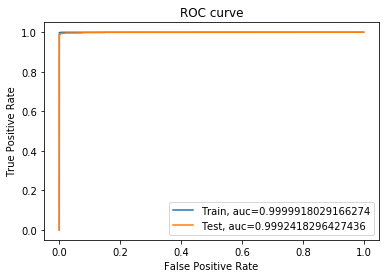

In [113]:
# Function to plot ROC curve 
roc_curve(gsc_rf, X_train, y_train, X_test, y_test)

### Feature Importance 

In [114]:
N = 10
importances = gsc_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in gsc_rf.estimators_],
             axis=0)

# Create a dataframe
importances_df = pd.DataFrame({'Variable':X.columns, 'Importance': importances})

top_N = importances_df.sort_values(by=['Importance'], ascending=False).head(10)

top_N

,Variable,Importance
10,1,0.080471
8,num_mentions,0.076479
9,0,0.052814
26,17,0.047293
12,3,0.045078
32,23,0.040018
11,2,0.036415
2,retweeted_status_id,0.036131
0,in_reply_to_status_id,0.031779
13,4,0.030439


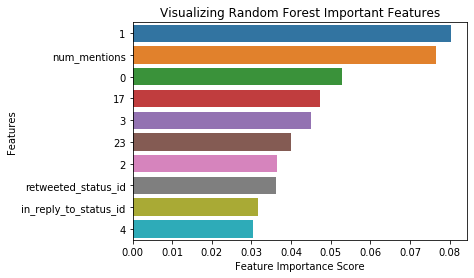

In [115]:
# Creating a bar plot
sns.barplot(y='Variable', x='Importance', data=top_N)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Random Forest Important Features")
plt.show()

### Multi-Layer Preceptron Neural Network

In [119]:
from sklearn.neural_network import MLPClassifier
# Establish and fit the model
mlp = MLPClassifier(max_iter=100) 
mlp.fit(X_train, y_train)
print(cross_val_score(mlp, X_train, y_train, cv=5))

y_pred = mlp.predict(X_test)
mlp.score(X_train, y_train)
# Default param(hidden_layer_sizes: 100, activation: ‘relu’, solver: adam’, alpha: 0.0001, learning_rate: ‘constant’)

[0.80429706 0.87739374 0.86898645 0.8869423  0.88457944]


0.8979305834540103

In [120]:
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("ROC_AUC: %.2f%%" % (roc_auc * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Recall:', recall_score(y_test, y_pred)*100,"%")
print('Precision:', precision_score(y_test, y_pred)*100,"%")
print(confusion_matrix(y_test, y_pred))

ROC_AUC: 89.13%
Accuracy: 89.34%
Recall: 90.99470276633313 %
Precision: 89.93600930773705 %
[[3559  519]
 [ 459 4638]]


In [ ]:
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

gsc_mlp = GridSearchCV(mlp, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
gsc_mlp.fit(X_train, y_train)
print(gsc_mlp.best_params_, gsc_mpl.best_score_)

## Supervised Learning Conclusion 

## Unsupervised Learning 

### K-means clustering

In [ ]:
# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_norm = normalize(X_tfidf)

# Reduce it to two components.
X_svd = svd.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))